In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchsummary import summary
import cv2
from skimage import io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
import pandas as pd
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu117
Torchvision Version:  0.15.2+cu117


In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

In [18]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f'Total Trainable Params: {total_params}')
    return total_params

count_parameters(model)

+--------------------------------------------+------------+
|                  Modules                   | Parameters |
+--------------------------------------------+------------+
|    backbone.body.layer2.0.conv1.weight     |   32768    |
|    backbone.body.layer2.0.conv2.weight     |   147456   |
|    backbone.body.layer2.0.conv3.weight     |   65536    |
| backbone.body.layer2.0.downsample.0.weight |   131072   |
|    backbone.body.layer2.1.conv1.weight     |   65536    |
|    backbone.body.layer2.1.conv2.weight     |   147456   |
|    backbone.body.layer2.1.conv3.weight     |   65536    |
|    backbone.body.layer2.2.conv1.weight     |   65536    |
|    backbone.body.layer2.2.conv2.weight     |   147456   |
|    backbone.body.layer2.2.conv3.weight     |   65536    |
|    backbone.body.layer2.3.conv1.weight     |   65536    |
|    backbone.body.layer2.3.conv2.weight     |   147456   |
|    backbone.body.layer2.3.conv3.weight     |   65536    |
|    backbone.body.layer3.0.conv1.weight

41102386

In [16]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 158.047MB


In [19]:
load_model = True
model_path = 'resnet50_mias_26092023'
num_classes = 7
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

if load_model:
    print('loading model...')
    model.load_state_dict(torch.load(model_path))
    print('model loaded')

loading model...
model loaded


In [8]:
def calc_mask_points(x, y):
    MASK_SIZE = 128
    y = 1024 - y
    x1 = int(x - MASK_SIZE)
    y1 = int(y - MASK_SIZE)
    x2 = int(x + MASK_SIZE)
    y2 = int(y + MASK_SIZE)
    return [x1,y1,x2,y2]

In [9]:
class All_mias(Dataset):
    """Mias mammography dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file, sep=' ').iloc[:,:-1].dropna()
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = {
            'CALC': 1,
            'CIRC': 2,
            'ARCH': 3,
            'SPIC': 4,
            'MISC': 5,
            'ASYM': 6,
             1: 'CALC',
             2: 'CIRC',
             3: 'ARCH',
             4: 'SPIC',
             5: 'MISC',
             6: 'ASYM',
        }


    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0] + ".pgm")
        image = io.imread(img_name)
        image = cv2.merge((image,image,image))
        
        detection_points = self.data.iloc[idx,4:6]
        bbox = calc_mask_points(detection_points[0],detection_points[1])

        annotation = self.data.iloc[idx,2]
        annotation = self.annotations[annotation]

        target = {
            'boxes': bbox,
            'labels': annotation
        }

        sample = (image,target)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
class Transform(object):

    def __call__(self,sample):
        image, target= sample[0], sample[1]
        image = image / 255
        return (image,target)
    

class ToTensor(object):
    
    def __call__(self, sample):
        image, target= sample[0], sample[1]
        image = torch.tensor(image, dtype=torch.float32)
        target['boxes'] = torch.FloatTensor(target['boxes'])
        target['labels'] = torch.tensor(target['labels'])

        return (image, target)

In [53]:
BATCH_SIZE = 1

dataset = All_mias(
        csv_file="Info.txt",
        root_dir="all-mias",
        transform=transforms.Compose([
                Transform(),
                ToTensor()
        ]))
lossFunc = MSELoss()
opt = Adam(model.parameters())
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [69]:
epochs = 50
steps = int(dataset.__len__()/BATCH_SIZE)

for epoch in range(epochs):
    step = 0
    model.train()
    for (image, target) in dataloader:
        step += 1

        image = np.reshape(image, (3,1024,1024))

        target['boxes'] = np.reshape( target['boxes'], (1,4))
        target['labels'] = np.reshape( target['labels'], (1))
   
        output = model([image], [target])

        cls_loss = output['loss_classifier']
        bbox_loss = output['loss_box_reg']
        print(f'epoch: {epoch+1} / {epochs} | step: {step} / {steps} | cls loss: {cls_loss:.7f} | bbox loss: {bbox_loss:.7f}')

epoch: 1 / 50 | step: 1 / 119 | cls loss: 1.8423516 | bbox loss: 0.0569145
epoch: 1 / 50 | step: 2 / 119 | cls loss: 1.8396580 | bbox loss: 0.0108792
epoch: 1 / 50 | step: 3 / 119 | cls loss: 1.8227655 | bbox loss: 0.0015860
epoch: 1 / 50 | step: 4 / 119 | cls loss: 1.8513875 | bbox loss: 0.0036557
epoch: 1 / 50 | step: 5 / 119 | cls loss: 1.8262080 | bbox loss: 0.0007272
epoch: 1 / 50 | step: 6 / 119 | cls loss: 1.8237330 | bbox loss: 0.0656647
epoch: 1 / 50 | step: 7 / 119 | cls loss: 1.8304583 | bbox loss: 0.0010420
epoch: 1 / 50 | step: 8 / 119 | cls loss: 1.7932227 | bbox loss: 0.0015935
epoch: 1 / 50 | step: 9 / 119 | cls loss: 1.8276582 | bbox loss: 0.0017311
epoch: 1 / 50 | step: 10 / 119 | cls loss: 1.8219066 | bbox loss: 0.0038962
epoch: 1 / 50 | step: 11 / 119 | cls loss: 1.8211873 | bbox loss: 0.0019113
epoch: 1 / 50 | step: 12 / 119 | cls loss: 1.8362557 | bbox loss: 0.0009574
epoch: 1 / 50 | step: 13 / 119 | cls loss: 1.8421392 | bbox loss: 0.0041181
epoch: 1 / 50 | step:

KeyboardInterrupt: 

In [15]:
# For inference
model.eval()
x = torchvision.io.read_image(path='cat.jpg')
x = torch.reshape(x, (1,3,640,612))
x = x /255
predictions = model(x)

In [72]:
img_path = "all-mias/mdb005.pgm"
image = io.imread(img_path)
image = cv2.merge((image,image,image))
image = torch.tensor(image, dtype=torch.float32)
image = torch.reshape(image, (1,3,1024,1024))
image = image / 255
model.eval()
pred = model(image)
pred

[{'boxes': tensor([[8.4279e+02, 1.1844e+02, 8.7994e+02, 2.4293e+02],
          [8.7483e+02, 1.2445e+02, 9.1974e+02, 2.5422e+02],
          [3.5495e+02, 0.0000e+00, 5.9108e+02, 6.5220e+02],
          [8.9736e+02, 1.1579e+02, 9.3611e+02, 2.5560e+02],
          [4.2717e+02, 0.0000e+00, 6.8323e+02, 6.1996e+02],
          [0.0000e+00, 0.0000e+00, 6.0827e+02, 7.0911e+02],
          [7.7037e+02, 1.1968e+02, 8.1682e+02, 2.4037e+02],
          [3.8564e+02, 1.4193e+02, 5.7693e+02, 8.6806e+02],
          [8.9840e+02, 1.2340e+02, 9.2683e+02, 1.9658e+02],
          [3.9114e+02, 0.0000e+00, 7.9856e+02, 4.2505e+02],
          [4.2707e+02, 4.3750e+02, 6.2351e+02, 9.7574e+02],
          [7.5881e+02, 1.9540e+01, 8.3680e+02, 2.3544e+02],
          [6.6722e+02, 1.3953e+02, 1.0240e+03, 1.0240e+03],
          [8.4665e+02, 1.1985e+02, 8.7437e+02, 1.8888e+02],
          [3.4608e+00, 3.5666e+02, 8.4076e+02, 6.4532e+02],
          [8.2464e+02, 6.0987e+01, 1.0240e+03, 2.6008e+02],
          [7.8994e+02, 1.3158e+

tensor([842.7919, 118.4374, 879.9395, 242.9317], grad_fn=<SelectBackward0>)
tensor(3)
tensor(0.3863, grad_fn=<SelectBackward0>)


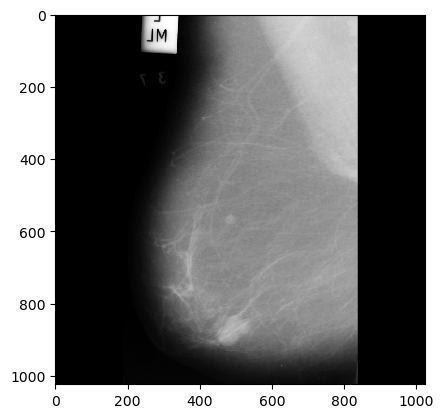

In [73]:
print(pred[0]['boxes'][0])
print(pred[0]['labels'][0])
print(pred[0]['scores'][0])
raw_img_path = img_path
raw_image = io.imread(raw_img_path)
raw_image = np.array(raw_image, dtype=np.float32)
raw_image = raw_image / 4
points = [int(x) for x in pred[0]['boxes'][0][0:4]]
# points = [742, 118, 779, 242]
points[1] = 1024 - points[1]
points[3] = 1024 - points[3]
for k in range(points[0],points[2]):
    for i in range(points[3],points[1]):
        if i >= 0 and k >= 0 and i <= 1024 and k <= 1024:
            raw_image[i][k] *= 4   
plt.imshow(raw_image, interpolation='nearest', cmap='gray')
plt.show()

In [37]:
raw_img_path = "all-mias/mdb005.pgm"
raw_img_path = 'cat.jpg'
raw_image = io.imread(raw_img_path)
raw_image = np.array(raw_image, dtype=np.float32)
raw_image /= 255
raw_image /= 4
points = [int(x) for x in pred[0]['boxes'][0][0:4]]
print(points) 
# points[1] = 1024 - points[1]
# points[3] = 1024 - points[3]
for k in range(points[0],points[2]):
    for i in range(points[1],points[3]):
        if i >= 0 and k >= 0 and i <= 1024 and k <= 1024:
            raw_image[i][k] *= 4   
# plt.imshow(raw_image, interpolation='nearest', cmap='gray')
plt.imshow(raw_image, interpolation='nearest')
plt.show()

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [16]:
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
labels = [weights.meta['categories'][x] for x in predictions[0]['labels']]
labels

['cat', 'cat', 'dog', 'bed', 'sheep']

In [74]:
model_path = 'resnet50_mias_29092023'
print('saving model...')
torch.save(model.state_dict(), model_path)
print('model saved')


saving model...
model saved


In [ ]:
print('loading model...')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
model.load_state_dict(torch.load(model_path))
print('model loaded')

In [18]:
# For inference
model.eval()
x = torchvision.io.read_image(path='cat.jpg')
x = torch.reshape(x, (1,3,640,612))
x = x /255
predictions = model(x)
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
labels = [weights.meta['categories'][x] for x in predictions[0]['labels']]
labels

['cat', 'cat', 'dog', 'bed', 'sheep']